The boston housing dataset is a classic benchmark regression task. The objective is to predict a set of house prices given a small set of features.

The meaning of the set of available features is shown below.

In [28]:
%load_ext autoreload
%autoreload 2
import os
import sys
module_path = os.path.abspath(os.path.join("../../../"))
if module_path not in sys.path:
    sys.path.append(module_path)

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [29]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_boston
data = load_boston()
print(data["DESCR"])

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

Lets initially benchmark the performance of an ElasticNetCV fitted across the entire dataset.

In [30]:
from sklearn.datasets import load_boston
data = load_boston()
X, y = data.data, data.target

from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
X = ss.fit_transform(X)
y = (y - y.mean()) / y.std()

from sklearn.linear_model import ElasticNetCV
reg = ElasticNetCV(l1_ratio=[.1, .5, .7, .9, .95, .99, 1], fit_intercept=True)

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
scores = cross_val_score(reg, X, y, cv=KFold(shuffle=True, random_state=42), scoring=None)#'neg_mean_absolute_error'
print(f'MAE: {np.mean(scores).mean():.3f}')

MAE: 0.700


## Linear DAGRegressor
The DAGRegressor has several parameters which can be used to better fit a more complicated noisy DAG:

- alpha: The l1 (lasso) regularisation parameter. Increasing this creates a sparser DAG.
- beta: The l2 (ridge) regularisation parameter.
It was decided to use alpha and beta rather than alpha and l1_ratio like in sklearn elasticnet to uncouple the parameters during optimisation.

There are several parameters which are also of interest which have good defaults, but we highlight here:

- dependent_target: This forces the target variable y to be only a child node. This is important for performance because in some cases X -> y is indistinguishable from y -> X. Enabling this (default enabled) ensures that the regressor performance at least matches linear regression. The trade-off is that the learned structure might be less accurate if y does cause other features.
- enforce_dag: This thresholds the learned structure model until the system is a DAG. This is useful for removing the small straggler connections which enables the DAG to be visualised easier. It does not impact performance, because the regressor still uses those connections under the hood.


CRIM       0.000000
ZN         0.000000
INDUS      0.000000
CHAS       0.000000
NOX        0.000000
RM         0.310018
AGE        0.000000
DIS       -0.224579
RAD        0.000000
TAX        0.000000
PTRATIO    0.000000
B          0.000000
LSTAT     -0.372827
dtype: float64


(<Figure size 837.36x526.32 with 1 Axes>, <AxesSubplot:>)

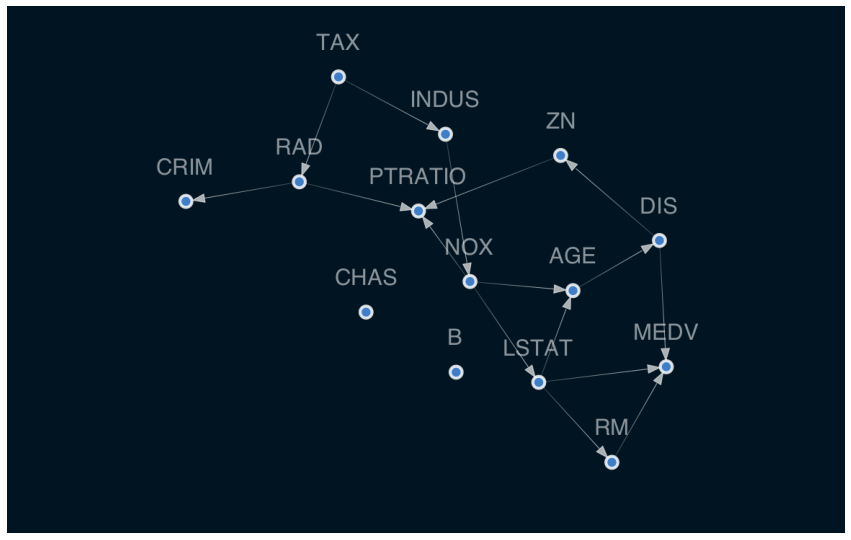

In [31]:
from sklearn.datasets import load_boston
data = load_boston()
X, y = data.data, data.target
names = data["feature_names"]

from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
X = ss.fit_transform(X)
y = (y - y.mean()) / y.std()

from causalnex.structure import DAGRegressor
reg = DAGRegressor(
    alpha=0.1,
    beta=0.9,
    hidden_layer_units=None,
    dependent_target=True,
    enforce_dag=True
)

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

X = pd.DataFrame(X, columns=names)
y = pd.Series(y, name="MEDV")
reg.fit(X, y)
print(pd.Series(reg.coef_, index=names))
reg.plot_dag(enforce_dag=True)
#scores = cross_val_score(reg, X, y, cv=KFold(shuffle=True, random_state=42), scoring=None)#
#print(f'MAE: {np.mean(scores).mean():.3f}')


## NonLinear DAGRegressor
Specifying a nonlinear model is extremely simple, only a single parameter needs to be altered: hidden_layer_units

hidden_layer_units takes any iterable of integers:

The value specifies the number of perceptrons to use in each nonlinear MLP layer:
The number of elements in the iterable determines the number of hidden layers.
The more layers and more perceptrons per layer, the more complicated the function which can be fit. The trade off is a greater tendency to overfit, and slower fitting.

A good default starting argument is ~[5]. This is unlikely to overfit, and usually demonstrates immediately whether the DAG has nonlinear components.

The setting of the alpha and beta parameters is very important. Typically beta is more important than alpha when using nonlinear layers. This is because l2 is applied across all layers, whereas l1 is only applied to the first layer. A good starting point is ~beta=0.5.

NOTE it is very important to scale your data!

The nonlinear layers contain sigmoid nonlinearities which can become saturated with unscaled data. Also, unscaled data means that regularisation parameters do not impact weights across features equally.

For convenience, setting standardize=True scales both the X and y data during fit. It also inverse transforms the y on predict similar to the sklearn TransformedTargetRegressor.

In [32]:
from sklearn.datasets import load_boston
data = load_boston()
X, y = data.data, data.target
names = data["feature_names"]

from causalnex.structure import DAGRegressor
reg = DAGRegressor(
    threshold=0.0,
    alpha=0.1,
    beta=0.9,
    hidden_layer_units=[5],
    standardize=True,
    enforce_dag=True,
)

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
scores = cross_val_score(reg, X, y, cv=KFold(shuffle=True, random_state=42))
print(f'MEAN R2: {np.mean(scores).mean():.3f}')

X = pd.DataFrame(X, columns=names)
y = pd.Series(y, name="MEDV")
reg.fit(X, y)
reg.plot_dag(enforce_dag=True)

AttributeError: 'DAGRegressor' object has no attribute 'target_dist_type'

In [27]:
from sklearn.datasets import load_boston
data = load_boston()
X, y = data.data, data.target
names = data["feature_names"]

from causalnex.structure import DAGRegressor
reg = DAGRegressor(
    alpha=0.1,
    beta=0.9,
    hidden_layer_units=[5],
    dependent_target=False,
    standardize=True,
    enforce_dag=True,
)

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
scores = cross_val_score(reg, X, y, cv=KFold(shuffle=True, random_state=42))
print(f'MEAN R2: {np.mean(scores).mean():.3f}')

X = pd.DataFrame(X, columns=names)
y = pd.Series(y, name="MEDV")
reg.fit(X, y)
print("MEAN EFFECT DIRECTIONAL:")
print(pd.Series(reg.coef_, index=names))
print("MEAN EFFECT MAGNITUDE:")
print(pd.Series(reg.feature_importances_, index=names))
reg.plot_dag(enforce_dag=True)

AttributeError: 'DAGRegressor' object has no attribute 'target_dist_type'